<a href="https://colab.research.google.com/github/nebirsad/qsar-cadd/blob/main/Dataset_Filteration_and_Analysis_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compound Filterations Based on ADME and Leadlikness**
My name is **Dr. Ashfaq Ahmad**, and this tutorial is inspired from the TechOpenCADD project of Volkamer Lab. With some minor modifications, I tried to made it available for the students working with a Biology background. For Proper understanding and learning, you can follow the video tutorial on **Bioinformatics Insights** https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg

This notebook is majorly designed for teaching purposes.

For citation and reading, https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x


**Aims and Objectives**

Compound filteration based on Lipinsik’s rule of five to keep only orally bioavailable compounds.

##**Basic Concepts**##
**1. ADME** - absorption, distribution, metabolism, and excretion

  2. Lead-likeness and Lipinski’s rule of five (Ro5)
  3. Radar charts in the context of lead-likeness

  In a virtual screening (molecular docking), our aim is to predict whether a compound might bind to a specific target. However, if we want to identify a new drug, it is also important that this compound reaches the target and is eventually removed from the body in a favorable way. Therefore, we should also consider whether a compound is actually taken up into the body and whether it is able to cross certain barriers in order to reach its target. Is it metabolically stable and how will it be excreted once it is not acting at the target anymore? These processes are investigated in the field of pharmacokinetics. In contrast to pharmacodynamics (“What does the drug do to our body?”), pharmacokinetics deals with the question “What happens to the drug in our body?”.

**ADME** - absorption, distribution, metabolism, and excretion:
Pharmacokinetics are mainly divided into four steps: Absorption, Distribution, Metabolism, and Excretion. These are summarized as ADME. Often, ADME also includes Toxicology and is thus referred to as ADMET or ADMETox. Below, the ADME steps are discussed in more detail (Wikipedia and Mol Pharm. (2010), 7(5), 1388-1405).

**Absorption:** The amount and the time of drug-uptake into the body depends on multiple factors which can vary between individuals and their conditions as well as on the properties of the substance. Factors such as (poor) compound solubility, gastric emptying time, intestinal transit time, chemical (in-)stability in the stomach, and (in-)ability to permeate the intestinal wall can all influence the extent to which a drug is absorbed after e.g. oral administration, inhalation, or contact to skin.

**Distribution:** The distribution of an absorbed substance, i.e. within the body, between blood and different tissues, and crossing the blood-brain barrier are affected by regional blood flow rates, molecular size and polarity of the compound, and binding to serum proteins and transporter enzymes. Critical effects in toxicology can be the accumulation of highly apolar substances in fatty tissue, or crossing of the blood-brain barrier.

**Metabolism:** After entering the body, the compound will be metabolized. This means that only part of this compound will actually reach its target. Mainly liver and kidney enzymes are responsible for the break-down of xenobiotics (substances that are extrinsic to the body).

**Excretion:** Compounds and their metabolites need to be removed from the body via excretion, usually through the kidneys (urine) or in the feces. Incomplete excretion can result in accumulation of foreign substances or adverse interference with normal metabolism.


##**Lead-likeness and Lipinski’s rule of five (Ro5)**
Molecular weight (MWT) <= 500 Da

Number of hydrogen bond acceptors (HBAs) <= 10

Number of hydrogen bond donors (HBD) <= 5

Calculated LogP (octanol-water coefficient) <= 5

**Additionally**

LogP is also called partition coefficient or octanol-water coefficient. It measures the distribution of a compound, usually between a hydrophobic (e.g. 1-octanol) and a hydrophilic (e.g. water) phase.

Hydrophobic molecules might have a reduced solubility in water, while more hydrophilic molecules (e.g. high number of hydrogen bond acceptors and donors) or large molecules (high molecular weight) might have more difficulties in passing phospholipid membranes.

##**Radar charts in the context of lead-likeness**
Molecular properties, such as the Ro5 properties, can be visualized in multiple ways (e.g. craig plots, flower plots, or golden triangle) to support the interpretation by medicinal chemists (Drug. Discov. Today (2011), 16(1-2), 65-72).

Due to their appearance, radar charts are sometimes also called “spider” or “cobweb” plots. They are arranged circularly in 360 degrees and have one axis, starting in the center, for each condition. The values for each parameter are plotted on the axis and connected with a line. A shaded area can indicate the region where the parameters meet the conditions.

In [3]:
! pip install rdkit-pypi
!pip install --upgrade rdkit-pypi

In [4]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

**As an example, and to quickly learn about the analysis, we will first pick entries for four molecules.** However, this step is not necessary - and you can skip it

In [5]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

Now we are going to combine the names and SMILES of the molecules, together with their structure, in a DataFrame.

In [6]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

Failed to patch pandas - unable to change molecule rendering


,name,smiles,ROMol
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ec900>
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee7a0>
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee340>
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee3b0>


**Time to calculate and Plot Molecular Properties using RDKit**

In [7]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue", "cyan"]
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]

,molecular_weight,n_hba,n_hbd,logp
0,1201.841368,12,5,3.26900
1,306.184447,4,1,1.68492
2,536.438202,0,0,12.60580
3,314.224580,2,2,5.84650


In [8]:
# Full preview
molecules

,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ec900>,1201.841368,12,5,3.26900,red
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee7a0>,306.184447,4,1,1.68492,green
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee340>,536.438202,0,0,12.60580,blue
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x7d87af0ee3b0>,314.224580,2,2,5.84650,cyan


In [9]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

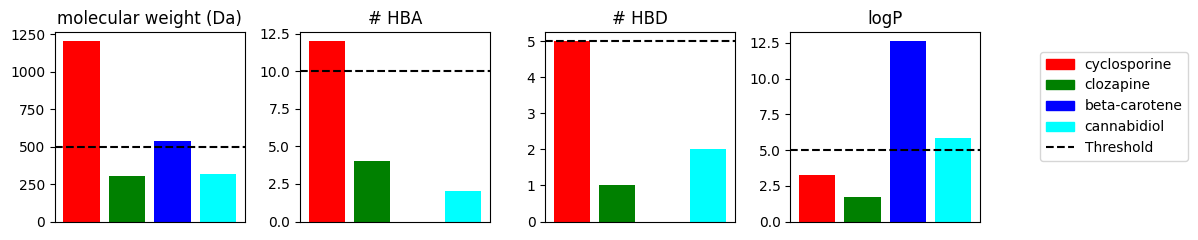

In [10]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

**Now we are interested to calculate that what are molecules that violates Ro5**

In [11]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [12]:
# NBVAL_CHECK_OUTPUT
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles)['ro5_fulfilled']}")

Ro5 fulfilled for cyclosporine: False
Ro5 fulfilled for clozapine: True
Ro5 fulfilled for beta-carotene: False
Ro5 fulfilled for cannabidiol: True


According to the Ro5, cyclosporin and betacarotene are estimated to have poor bioavailability. However, since all of them are approved drugs, they are good examples of how the Ro5 can be used as an alert but should not necessarily be used as a filter very strictly.

##Come to the Real Bussiness
Now we are going to upload our dataset, which was prepared in Part-1 for actuall calculations.

In [13]:
molecules = pd.read_csv("/content/ndm_dataset1.csv", index_col=0)
print(molecules.shape)
molecules.head()

(32, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL3810052,150.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3)[nH]2)cc1,6.823909
1,CHEMBL3809576,160.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1cccc(Cl)c1,6.795880
2,CHEMBL3808671,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3O)[nH]2)cc1,6.795880
3,CHEMBL3809719,160.0,nM,Cc1ccccc1NC(=O)CSc1nnc(-c2ccccc2O)[nH]1,6.795880
4,CHEMBL3809806,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3N)[nH]2)cc1,6.795880


Perform **Ro5** calculations on all compounds

In [14]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,366.151432,4,2,4.54510,True
1,360.044774,5,3,3.56150,True
2,382.146347,5,3,4.25070,True
3,340.099397,5,3,3.21652,True
4,381.162331,5,3,4.12730,True


Concatenate molecules with Ro5 data calculations

In [15]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3810052,150.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3)[nH]2)cc1,6.823909,366.151432,4,2,4.54510,True
1,CHEMBL3809576,160.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1cccc(Cl)c1,6.795880,360.044774,5,3,3.56150,True
2,CHEMBL3808671,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3O)[nH]2)cc1,6.795880,382.146347,5,3,4.25070,True
3,CHEMBL3809719,160.0,nM,Cc1ccccc1NC(=O)CSc1nnc(-c2ccccc2O)[nH]1,6.795880,340.099397,5,3,3.21652,True
4,CHEMBL3809806,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3N)[nH]2)cc1,6.795880,381.162331,5,3,4.12730,True


In [16]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 32
# compounds in filtered data set: 32
# compounds not compliant with the Ro5: 0


Why not save them

In [28]:
#This script will save the unfiltered data
molecules.to_csv('/content/ndm_ro5_properties.csv', index=True)

In [29]:
#This will Save filtered data
molecules_ro5_fulfilled.to_csv('/content/ndm_ro5_properties_filtered.csv')
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3810052,150.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3)[nH]2)cc1,6.823909,366.151432,4,2,4.54510,True
1,CHEMBL3809576,160.0,nM,O=C(CSc1nnc(-c2ccccc2O)[nH]1)Nc1cccc(Cl)c1,6.795880,360.044774,5,3,3.56150,True
2,CHEMBL3808671,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3O)[nH]2)cc1,6.795880,382.146347,5,3,4.25070,True
3,CHEMBL3809719,160.0,nM,Cc1ccccc1NC(=O)CSc1nnc(-c2ccccc2O)[nH]1,6.795880,340.099397,5,3,3.21652,True
4,CHEMBL3809806,160.0,nM,CCCCc1ccc(NC(=O)CSc2nnc(-c3ccccc3N)[nH]2)cc1,6.795880,381.162331,5,3,4.12730,True


##Lets calculate/Visualize Ro5 Analysis on Radar Plot for the Data

In [19]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

Some statistics for the filtered dataset calculated above

In [20]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,326.653470,54.081706
n_hba,4.406250,1.103057
n_hbd,2.500000,1.047270
logp,3.060461,1.293778


Molecules that violates the Ro5

In [21]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,NaN,NaN
n_hba,NaN,NaN
n_hbd,NaN,NaN
logp,NaN,NaN


Define helper functions to prepare data for radar plotting¶
In the following, we will define a few helper functions that are only used for radar plotting.

**Prepare y values:** The properties used for the Ro5 criteria are of different magnitudes. The MWT has a threshold of 500, whereas the number of HBAs and HBDs and the LogP have thresholds of only 10, 5, and 5, respectively. In order to visualize these different scales most simplistically, we will scale all property values to a scaled threshold of 5:

scaled property value = property value / property threshold * scaled property threshold

scaled MWT = MWT / 500 * 5 = MWT / 100

scaled HBA = HBA / 10 * 5 = HBA / 2

scaled HBD = HBD / 5 * 5 = HBD

scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.

In [22]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

**Prepare x values:** The following helper function returns the angles of the physicochemical property axes for the radar chart. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.

In [23]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

Now generate Radar Plot

In [24]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

Now here we will generate two Radar plots. One for the filtered data (which satisfy the Ro5) and vice versa.

In [25]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

**1. Radar Plot for Filtered Dataset**

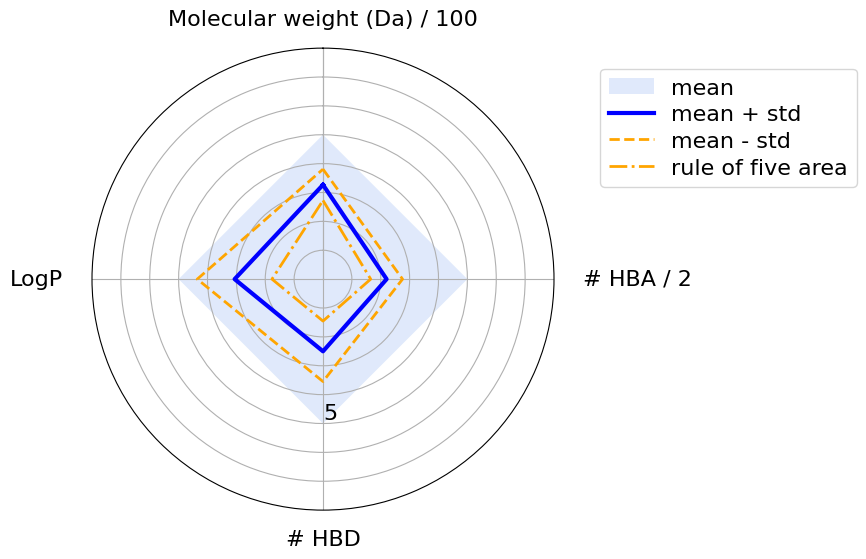

In [26]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

Radar plot for the molecules that violated the Ro5

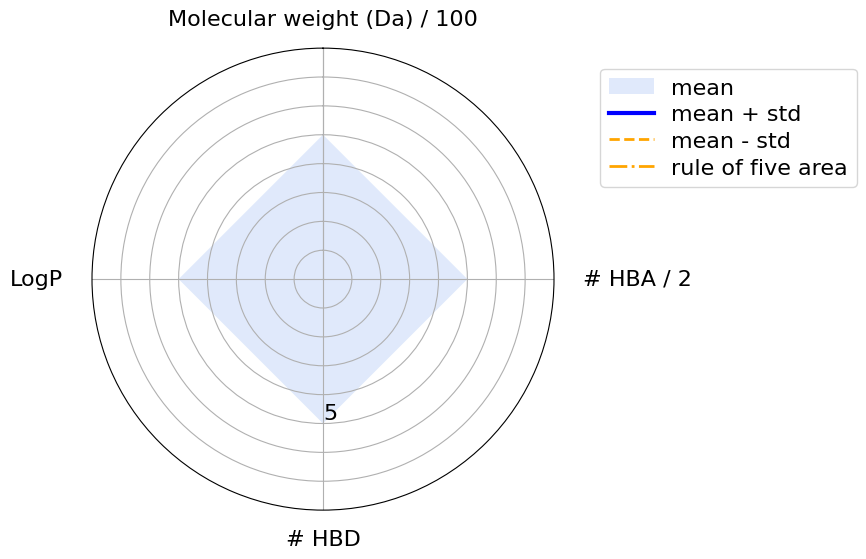

In [30]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)


The blue square shows the area where a molecule’s physicochemical properties are compliant with the Ro5. The blue line highlights the mean values, while the orange dashed lines show the standard deviations. We can see that the mean values never violate any of Lipinski’s rules. However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. This is acceptable because, according to the Ro5, one of the four rules can be violated.

**In the case of violated compunds we can see that logP and MW violated**

##**Congratulation! You are progressiing well in learning something new**

If you happy for your time, Please provide your Support in the Form of a Subscription on Youtube Channel**

[**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

Follow [**WhatsApp Channel**](https://whatsapp.com/channel/0029VajkwkdCHDydS6Y2lM36) for further updates, research services, and courses.